In [2]:
#load aiida environment and connect to database
from aiida import load_profile

profile = load_profile()
print('profile name : ',profile.name)
print('profile database host name : ',profile.database_hostname)
print('default user : ',profile.default_user)
import seaborn as sns

profile name :  default
profile database host name :  localhost
default user :  r.mozumder@fz-juelich.de


In [3]:
# load classes and functions
from aiida.orm import CifData, Code, Dict, load_node, StructureData 
from aiida.orm import (Group, load_group, load_node, load_code, groups,
                      WorkChainNode)
from aiida.engine import submit, exceptions
from aiida.common.exceptions import NotExistent
from aiida_kkr.workflows import kkr_imp_sub_wc, kkr_imp_dos, kkr_imp_wc, kkr_startpot_wc
import numpy as np
from aiida_kkr.calculations import KkrimpCalculation, VoronoiCalculation
import matplotlib.pyplot as plt
from aiida_kkr.tools.common_workfunctions import get_username
import matplotlib.gridspec as gridspec
from aiida_kkr.tools import plot_kkr


In [4]:
## This is the more stable and smart one
### To extract data from the two combine impurities as well as single imp to plot :
## In this step if 
def ExtractLastCalcData(group_pk, Average= True, **kargs):
    
    """
    param: group_pk : Only excepts the Identifier or label 
    param: kargs : key_pair_value1, key_pair_value2, to search for data from  the last_calc_output_param.
                   The keys are "key of keys"
                    e.i. last_calc_output_param[value1][value2].
    """
    import numpy as np
    from aiida.common.constants import elements as elmt
    import math

    sym_to_zimp = {elmt[zimp]['symbol']:zimp for zimp in elmt.keys()}
    
    combine_imps_group = load_group(group_pk)
    combine_nodes_list = list(combine_imps_group.nodes)
    plot_zimp_row_list = []  # list of imp along the y-axis
    plot_zimp_col_list = [0] # list of imp along the x-axis this extra '0' is indented for singel imp

    for node in combine_nodes_list[:]:
        ## Here to arrange the imps for once, intending for x-axis, plot_col_list, and for y-axis, plot_row_list 
        
        zimp1, zimp2 = sym_to_zimp[node.label.split(':')[0]], sym_to_zimp[node.label.split(':')[1]]
        ## Here only one imp will be consider for once
        if zimp1 not in plot_zimp_row_list:
            plot_zimp_row_list.append(zimp1)
        if zimp2 not in plot_zimp_col_list:
            plot_zimp_col_list.append(zimp2)

    plot_zimp_row_list.sort()
    plot_zimp_col_list.sort()
            
    # This is the list considered as the label for yticks
    plot_imp_row_list = [elmt[zimp]['symbol'] for zimp in plot_zimp_row_list]
    # This is the list considered as the label for xticks
    plot_imp_col_list = [elmt[zimp]['symbol'] for zimp in plot_zimp_col_list]

    print('len of plot_imp_row_list', len(plot_imp_row_list))
    print('len of plot_imp_col_list', len(plot_imp_col_list))

    # Extract all the total_spin_momentum from the combine_imps_wc as well as single impurity
    def extract_last_calc_data(combine_nodes_list, **kargs):
        node_list = combine_nodes_list
        extr_comb_dict = {}
        extr_single_dict = {}
        already_search_imp_list= []
 #       i= 0
 #       i_max= 20
        
        for nod in node_list[:]:
            single_imp_wc = nod.inputs.impurity1_output_node.get_incoming(node_class=kkr_imp_wc).first().node
            zimp= single_imp_wc.inputs.impurity_info.get_dict()['Zimp']
            if zimp not in already_search_imp_list:
                already_search_imp_list.append(zimp)
                ## Now collect the spin_data
                # try:
                out_dict = single_imp_wc.outputs.last_calc_output_parameters.get_dict()
                for val in kargs.values():
                    out_dict =  out_dict[val]
                single_imp_val = out_dict
                #except:
                 #   single_imp_val = np.nan
                    
                imp1_symbol= elmt[zimp]['symbol']
                extr_single_dict[imp1_symbol]= single_imp_val
 #               print(f"test for single imp, pk: {(single_imp_wc.pk, single_imp_wc.label)}, keys: {kargs.keys()}, data: {single_imp_val}")

            key= nod.label.split(':')[0] + nod.label.split(':')[1]
            
#            try:
            out_dict = nod.outputs.last_calc_output_parameters.get_dict()
            for val in kargs.values():
                out_dict =  out_dict[val]
            val = out_dict
#            except:
#            val = np.nan
            extr_comb_dict[key]= val
#            if i<i_max:
 #               print(f"test for dimar imps, pk: {nod.pk, nod.label}, keys: {kargs.keys()}, data: {val}")
 #               i+=1
        return extr_comb_dict, extr_single_dict

    # To fill the 2d plot data from the kkrimp_last_calc
    impcalc_data_array = np.zeros(shape= (len(plot_imp_row_list), len(plot_imp_col_list)), dtype= float)
    extr_comb_dict, extr_single_dict = extract_last_calc_data(combine_nodes_list, **kargs)
    row_index= 0
    col_index= 1 # Here the index '0' is skiped as it is fillled with empty string 'xx'
                 # and the coresponding column will be filles with the data extracted
                 # from the singel imp calc data

    for imp1 in plot_imp_row_list[:]:
        col_index = 1
        for imp2 in plot_imp_col_list[1:]:

            if col_index==1:
                ## Here the first column will be fullfiled with the single im_data
                impcalc_data_array[row_index, col_index-1] = extr_single_dict[imp1]
            search_key = plot_imp_row_list[row_index]  + plot_imp_col_list[col_index]
            if search_key in  extr_comb_dict.keys():
                impcalc_data_array[row_index, col_index] =  extr_comb_dict[search_key]
            else:
                impcalc_data_array[row_index, col_index] =  np.nan 

            col_index += 1
        row_index += 1

    plot_data_shape = np.shape(impcalc_data_array)
    if Average:
        CutCol= plot_imp_col_list[1:]
        ## Doing the transpose matrix
        ## In the single cut array first col will be removed from the array
        CutArr= impcalc_data_array[:, 1:]
        for imp1 in plot_imp_row_list:
            y_index= plot_imp_row_list.index(imp1)
            
            for imp2 in CutCol:
                x_index= CutCol.index(imp2)
                if math.isnan(CutArr[x_index,y_index]):
#                    print(f'imp1:imp2= {imp1}:{imp2}, index= {x_index, y_index}, exch_index= {y_index, x_index}')
                    exch_row_col_val= CutArr[y_index,x_index]
                    CutArr[x_index, y_index]= exch_row_col_val
                
        CutArrTrans= CutArr.T
        CutArr+= CutArrTrans
        impcalc_data_array[:,1:]= CutArr/2
        impcalc_data_array = impcalc_data_array
    
    print(plot_imp_col_list)
    print(plot_imp_row_list)
    
    return impcalc_data_array, plot_imp_col_list, plot_imp_row_list

## To extract the data from jij calcculation
def ExtractJijData(group_pk, jij_data_position:int=None, D_dev_J=None, atoms_info: bool= True, Average= True):
    from aiida_kkr.calculations import KkrCalculation
    import math

    """
    param: group_pk : Only excepts the ID
    
    jij_data_position: (0: dr_1, 1:dr_2, 2:dr_3)distance between atoms, 3:J, 4:D(abs value),
                        5:Dx, 6:Dy, 7:Dz  
    D_dev_J: True, to calculate the D J ratio
    atoms_info: To get the atom indices
    Average: To average the ndarray specialy for 
    param: kargs : key_1, key2, to search for data from  the last_calc_output_param 
    """
    import numpy as np
    from aiida.common.constants import elements as elmt
    sym_to_zimp = {elmt[zimp]['symbol']:zimp for zimp in elmt.keys()}
    
    combine_imps_group = load_group(group_pk)
    combine_nodes_list = list(combine_imps_group.nodes)
    plot_zimp_row_list = []  # This is the list considered as zimp along the y-axis
    plot_zimp_col_list = []  # This is the list considered as zimp along the x-axis

    for node in combine_nodes_list[:]:
        ## Here to arrange the imps for once, intending for x-axis, 
        ## plot_col_list, and y-axis, plot_row_list 
        
        zimp1, zimp2 = sym_to_zimp[node.label.split(':')[0]], sym_to_zimp[node.label.split(':')[1]]
        ## Here only one imp will be consider for once
        if zimp1 not in plot_zimp_row_list:
            plot_zimp_row_list.append(zimp1)
        if zimp2 not in plot_zimp_col_list:
            plot_zimp_col_list.append(zimp2)
    
    plot_zimp_row_list.sort()
    plot_zimp_col_list.sort()

    # This is the list considered as the label for yticks
    plot_imp_row_list = [elmt[zimp]['symbol'] for zimp in plot_zimp_row_list]
    # This is the list considered as the label for yticks
    plot_imp_col_list = [elmt[zimp]['symbol'] for zimp in plot_zimp_col_list]

    print('len of plot_imp_row_list', len(plot_imp_row_list))
    print('len of plot_imp_col_list', len(plot_imp_col_list))

    # Extract the JijData and JijInfo from the list of combined_imps_node_list
    def extract_jij(combine_nodes_list, jij_data_position:int=None, D_dev_J=None, atoms_info: bool= True):
        node_list = combine_nodes_list
        extr_comb_dict = {}
# del         extr_single_dict = {}
# del         already_search_imp_list= []
# TODO: delete the line with #del 

        Jij_data = None
        some_info_dict = {}
        for nod in node_list[:]:
            key= nod.label.split(':')[0] + nod.label.split(':')[1]
        
            if jij_data_position in [3,4]:
                Jij_data = nod.outputs.JijData.get_array('JijData')[0,:]
                Jij_info = nod.outputs.JijInfo.get_dict()['text'].split('\n')[3].split()
                extr_comb_dict[key]= Jij_data[jij_data_position]
            elif  D_dev_J==True:
                Jij_data = nod.outputs.JijData.get_array('JijData')[0,:]
                Jij_info = nod.outputs.JijInfo.get_dict()['text'].split('\n')[3].split()
                d_j = Jij_data[4]/Jij_data[3]
                extr_comb_dict[key] = d_j
            else:
                print('provide valid input in the funcion ExtractJijData.')
        try:
            kkr_calc= combine_nodes_list[0].outputs.remote_data_gf.get_incoming(node_class=KkrCalculation).all()[0].node
        except:
            kkr_calc= combine_nodes_list[0].inputs.gf_host_remote.get_incoming(node_class=KkrCalculation).all()[0].node
        kkr_output_dict= kkr_calc.outputs.output_parameters.get_dict()
        
# TODO: Add a if statement to take into account only jij_position or D_div_J

## This section regarding for two impurities 
        if atoms_info:
            dist = np.sqrt(np.sum([i**2 for i in Jij_data[0:3]]))
            imps_index = (int(Jij_info[0]), int(Jij_info[1]))
            some_info_dict = {'some_info':{ 'imp_indices' : imps_index ,
                                            'atom_distance' : dist,
                                            'alat' :kkr_output_dict['alat_internal'],
                                            'alat_unit': 'Bohr'
                                            }
                             }

        return extr_comb_dict, some_info_dict #, extr_single_dict

    # To fill the 2d plot data here
    jij_data_array = np.zeros(shape= (len(plot_imp_row_list), len(plot_imp_col_list)), dtype= float)
    extr_comb_dict, some_info_dict = extract_jij(combine_nodes_list, jij_data_position=jij_data_position, D_dev_J=D_dev_J, atoms_info=atoms_info)
    row_index= 0
    col_index= 0 # Here the index '0' is skiped as it is fillled with empty string 'xx'
                 # and the coresponding column will be filles with the data extracted
                 # from the singel imp calc data

    for imp1 in plot_imp_row_list[:]:
        col_index = 0
        for imp2 in plot_imp_col_list[:]:

            search_key = plot_imp_row_list[row_index]  + plot_imp_col_list[col_index]
            if search_key in  extr_comb_dict.keys():
                jij_data_array[row_index, col_index] =  extr_comb_dict[search_key]
            else:
                jij_data_array[row_index, col_index] =  np.nan 

            col_index += 1
        row_index += 1
## Average the map 
    if Average:
        
        for imp1 in plot_imp_row_list:
            y_index= plot_imp_row_list.index(imp1)
            for imp2 in plot_imp_col_list:
                x_index= plot_imp_col_list.index(imp2)
                if math.isnan(jij_data_array[x_index,y_index]):
                    exch_row_col_val= jij_data_array[y_index,x_index]
                    jij_data_array[x_index, y_index]= exch_row_col_val
        
        JijDataTr= jij_data_array.T
        jij_data_array += JijDataTr
        jij_data_array = jij_data_array/2

    plot_data_shape = np.shape(jij_data_array)
    
    return jij_data_array, plot_imp_col_list, plot_imp_row_list, some_info_dict


In [24]:
### Plot the figures for any specific group
group = 102
def diamar_plot(group, with_seaborn= False, 
                save_intofile=False,
                Average= False,
                dict_for_last_calc_data= None,
                spin_data= True,
                Jij_data= True, 
                DM_data_array= True,
                DRatioJ_data_array= True,
                plot_with_difference= False,
                file_name= None):
    """
        dict_for_last_calc_data (dict): To extract the data from the last calc
        plot_with_differnce, bool: This will plot value-difference between
                                the First_imp from the single_imp_wc and first_imp from the mutiple_imp_wc.
                                This mainly introduces because how propertise of the first_imp is changed due to
                                the other induced imp. Other the plot will for the exact value found in the calculation  
    """
    group_label= load_group(group).label
    ## Collect plot data
    if dict_for_last_calc_data==None:
        dict_for_last_calc_data= {'key1' : 'magnetism_group',  
                                  'key2' : 'total_spin_moment'}
    
    #plot_data
    array_data = []    
    
    if spin_data:
        spin_data_array, spin_xtick_labels, spin_ytick_labels = ExtractLastCalcData(group, Average= Average, 
                                                                                **dict_for_last_calc_data)
        #print(data_shape= np.shape(spin_data))
        if plot_with_difference:
            data_shape= np.shape(spin_data_array)
            for row_num in range(data_shape[0]):
                spin_data_array[row_num,1:] = spin_data_array[row_num,1:]-spin_data_array[row_num,0]
        array_data.append(spin_data_array)
    if Jij_data:
        Jij_data_array, Jij_xtick_labels, Jij_ytick_labels, some_info_dict  = ExtractJijData(group, 
                                                                                         jij_data_position=3)
        array_data.append(Jij_data_array)
    if DM_data_array:
        DM_data_array, DM_xtick_labels, DM_ytick_labels, some_info_dict = ExtractJijData(group, 
                                                                                     jij_data_position=4)
        array_data.append(DM_data_array)
    if DRatioJ_data_array:
        DRatioJ_data_array, DRatioJ_xtick_labels, DRatioJ_ytick_labels, some_info_dict = ExtractJijData(group, 
                                                                                                    D_dev_J=True)
        array_data.append(DRatioJ_data_array)
    
    ## starts ploting
    import matplotlib.pyplot as plt
    import matplotlib
    from matplotlib import ticker
    %matplotlib inline
    import seaborn as sns    

    xtick_points = [list(range(np.shape(spin_data_array)[1])), list(range(np.shape(Jij_data_array)[1])), list(range(np.shape(DM_data_array)[1])), list(range(np.shape(DRatioJ_data_array)[1]))]
    # xtick_points = np.add(xtick_points, 0.5)#.tolist()

    xtick_labels = [spin_xtick_labels, Jij_xtick_labels, DM_xtick_labels, DRatioJ_xtick_labels]

    ytick_points = [list(range(np.shape(spin_data_array)[0])), list(range(np.shape(Jij_data_array)[0])), list(range(np.shape(DM_data_array)[0])), list(range(np.shape(DRatioJ_data_array)[0]))]
    ytick_labels = [spin_ytick_labels, Jij_ytick_labels, DM_ytick_labels, DRatioJ_ytick_labels]

    array_data = [spin_data_array, Jij_data_array, DM_data_array, DRatioJ_data_array]
    label_x_y = [['imp2','imp1'], ['imp2','imp1'], ['imp2','imp1'],  ['imp2','imp1']]
    title = ['imp1 mag mom changes induced by second imp', 'Jij interaction for combine_imps_plot'
            , 'Dzyaloshinskii-Moriya', 'D/J' ]

    fig, axs = plt.subplots(2,2, constrained_layout=True, figsize=(20,15), )

    # fig.figsize
    cmap0 = plt.cm.get_cmap('winter')#.set_bad(color='white', )
    norm0 = None

    ### here to create the color map as cmap

    bounds = [-100,-0.01,0.01,100]
    colors = ["r", "b", "g"]
    cmap1 = matplotlib.colors.ListedColormap(colors )
    norm1 = matplotlib.colors.BoundaryNorm(bounds, len(colors))
    #TODO: Change the label points to the locator
    ### create cmap ends here
    cmap = [cmap0, cmap0, cmap0, cmap0]
    norm = [norm0, norm0, norm0, norm0]
    #                        norm=mpl.colors.Normalize(vmin=-0.5, vmax=1.5))
    #cbar.set_clim(-2.0, 2.0)
    i = 0
    for ax in axs.ravel():
        if len(axs.ravel()) > len(array_data):
            continue
        #img = ax.pcolormesh(array_data[i], cmap=cmap[i], norm=norm[i], rasterized=True)

        if i==3:
            
            if with_seaborn:
                sns.heatmap(np.round(array_data[i], decimals=2), ax=ax, annot=True)
            # with matplot
            else:
                img = ax.pcolormesh(array_data[i], cmap=cmap[i], norm=norm[i], rasterized=True, vmin=-5, vmax=5)
        else:
            
            if with_seaborn:
                sns.heatmap(np.round(array_data[i], decimals=2), ax=ax, annot=True)
            # Plot with matplot
            else:
                img = ax.pcolormesh(array_data[i], cmap=cmap[i], norm=norm[i], rasterized=True)
                
        if not with_seaborn:
            cm = fig.colorbar(img, ax=ax)
        
        ## Centering the xtick with formatter and locator
        xtick_locator = np.add(xtick_points[i], 0.5).tolist()
        ax.xaxis.set_major_formatter(ticker.NullFormatter())
        ax.xaxis.set_major_locator(ticker.NullLocator())
        ax.xaxis.set_minor_locator(ticker.FixedLocator(xtick_locator))
        ax.xaxis.set_minor_formatter(ticker.FixedFormatter(xtick_labels[i]))

        ## centring the yticks with formatter and locator
        ytick_locator = np.add(ytick_points[i], 0.5).tolist()
        ax.yaxis.set_major_locator(ticker.NullLocator())
        ax.yaxis.set_major_formatter(ticker.NullFormatter())
        ax.yaxis.set_minor_locator(ticker.FixedLocator(ytick_locator))
        ax.yaxis.set_minor_formatter(ticker.FixedFormatter(ytick_labels[i]))


        ax.set_xlabel(label_x_y[i][0])
        ax.set_ylabel(label_x_y[i][1])
        ax.set_title(title[i])
    #     ax.xti
        i += 1


    imp_index = some_info_dict['some_info']['imp_indices']
    atom_distance = some_info_dict['some_info']['atom_distance']
    alat = some_info_dict['some_info']['alat']
    msg = f'imp_index: {imp_index}, Distance: {atom_distance} alat; 1 alat= {alat} Bohr'
    plt.figtext(x=0.35,y=0.5,s=msg)
    
    if save_intofile:
        if file_name:
            pdf_title= file_name
        else:
            pdf_title= group_label +'.pdf'
        plt.savefig(pdf_title)

len of plot_imp_row_list 20
len of plot_imp_col_list 21
['X', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd']
['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd']
len of plot_imp_row_list 20
len of plot_imp_col_list 20
len of plot_imp_row_list 20
len of plot_imp_col_list 20
len of plot_imp_row_list 20
len of plot_imp_col_list 20


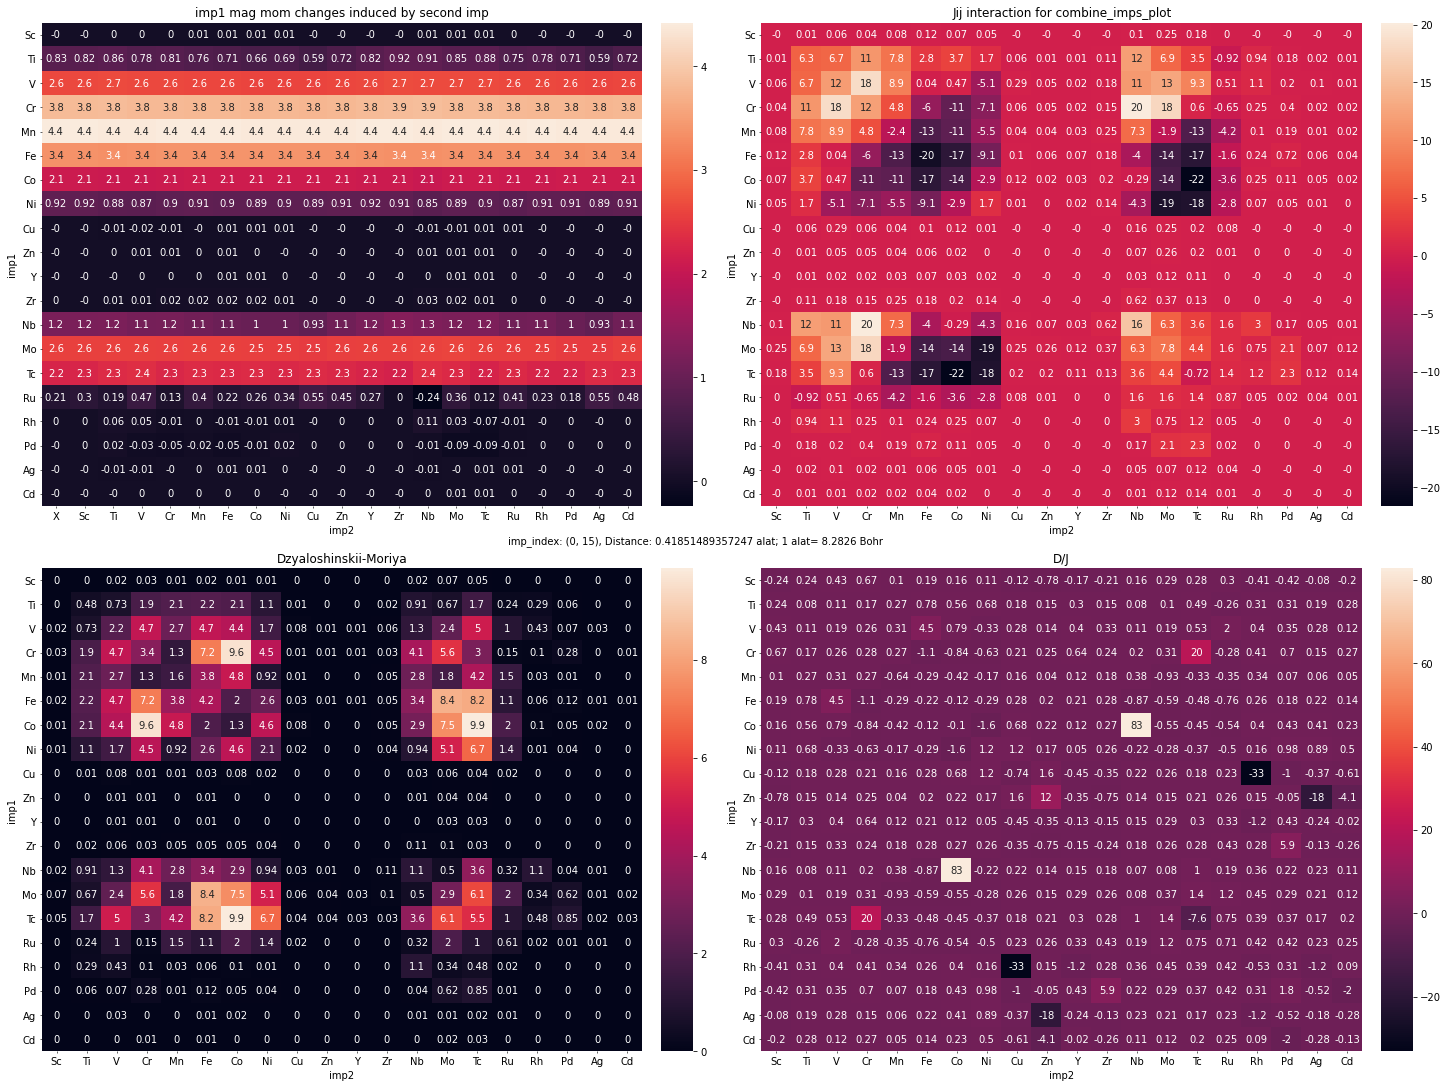

In [29]:
dict_for_last_calc_data= {'key1':'magnetism_group',
                          'key2':'spin_moment_per_atom',
                          'key3': 0,
                          'key4': 2
                         }
group_pk= 102
file_name= 'imp1_magnetic_moment__'+ load_group(group_pk).label+'.pdf'
diamar_plot(group_pk, with_seaborn=True, dict_for_last_calc_data=dict_for_last_calc_data, Average= False, plot_with_difference=False, file_name=file_name, save_intofile= True)#, DM_data_array=False,DRatioJ_data_array=False,Jij_data=False) # 


len of plot_imp_row_list 20
len of plot_imp_col_list 21
['X', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd']
['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd']
len of plot_imp_row_list 20
len of plot_imp_col_list 20
len of plot_imp_row_list 20
len of plot_imp_col_list 20
len of plot_imp_row_list 20
len of plot_imp_col_list 20


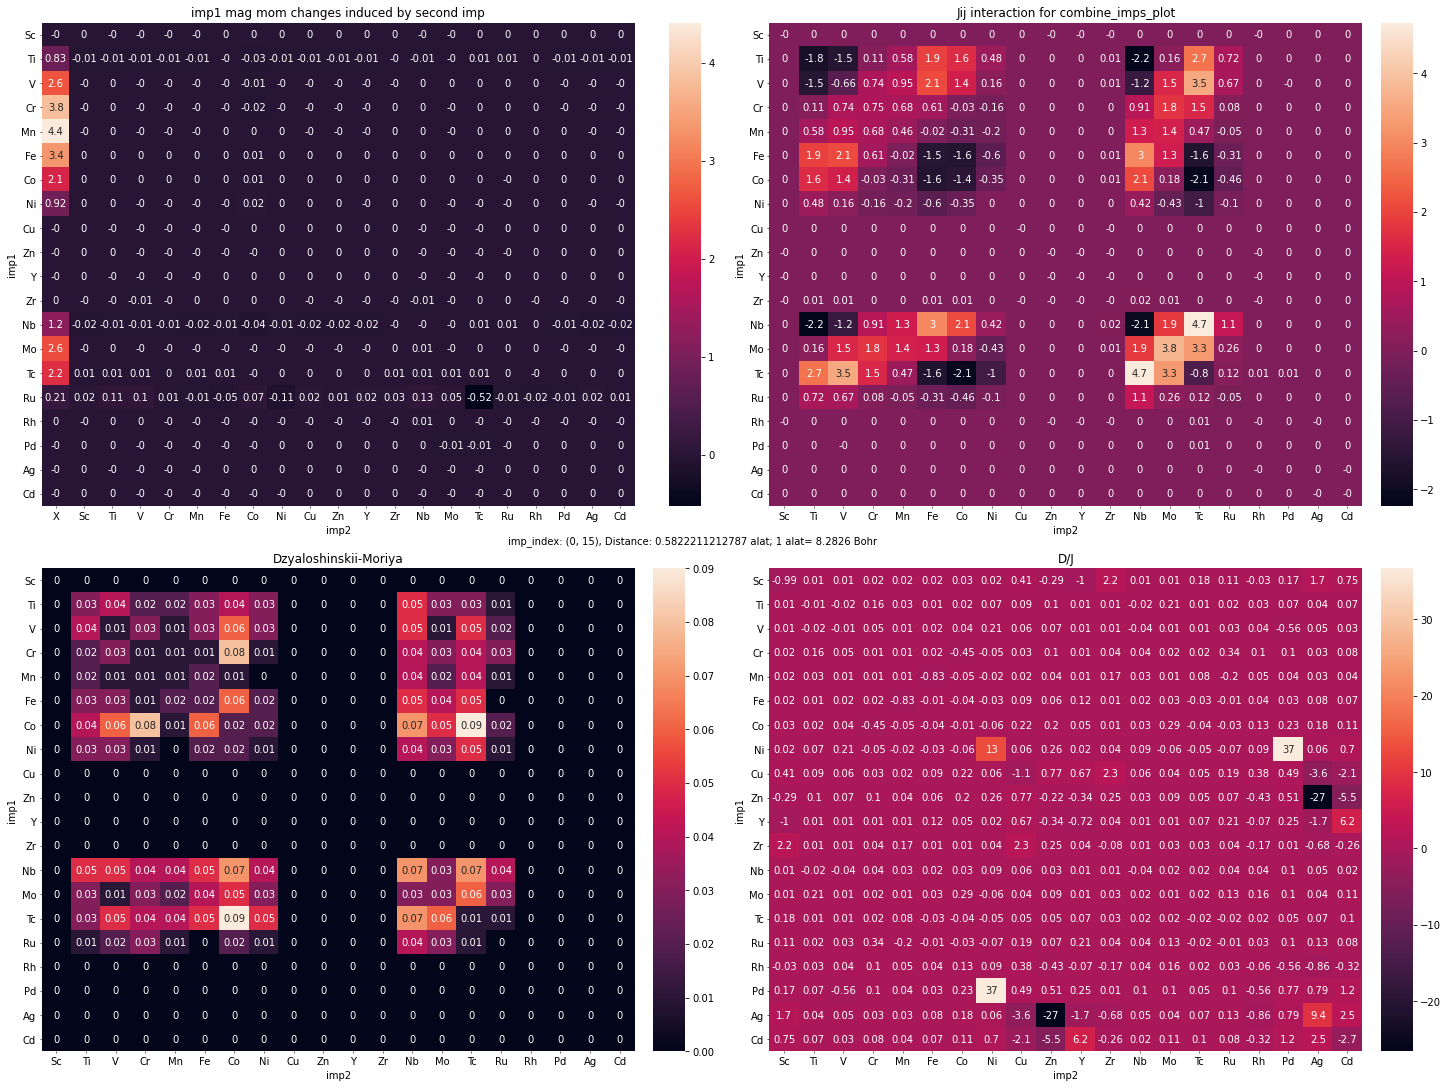

In [30]:
group_pk= 104
file_name= 'imp1_magnetic_moment__'+ load_group(group_pk).label+'.pdf'
diamar_plot(group_pk, with_seaborn=True, dict_for_last_calc_data=dict_for_last_calc_data, Average= False, plot_with_difference=True, file_name=file_name, save_intofile= True)#, DM_data_array=False,DRatioJ_data_array=False,Jij_data=False) # 


In [ ]:
group_pk= 115
file_name= 'imp1_magnetic_moment__'+ load_group(group_pk).label+'.pdf'
diamar_plot(group_pk, with_seaborn=True, dict_for_last_calc_data=dict_for_last_calc_data, Average= False, plot_with_difference=True, file_name=file_name, save_intofile= True)#, DM_data_array=False,DRatioJ_data_array=False,Jij_data=False) # 


len of plot_imp_row_list 20
len of plot_imp_col_list 21
['X', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd']
['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd']
len of plot_imp_row_list 20
len of plot_imp_col_list 20
len of plot_imp_row_list 20
len of plot_imp_col_list 20
len of plot_imp_row_list 20
len of plot_imp_col_list 20


In [ ]:
group_pk= 118
file_name= 'imp1_magnetic_moment__'+ load_group(group_pk).label+'.pdf'
diamar_plot(group_pk, with_seaborn=True, dict_for_last_calc_data=dict_for_last_calc_data, Average= False, plot_with_difference=True, file_name=file_name, save_intofile= True)#, DM_data_array=False,DRatioJ_data_array=False,Jij_data=False) # 


len of plot_imp_row_list 20
len of plot_imp_col_list 21
['X', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd']
['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd']


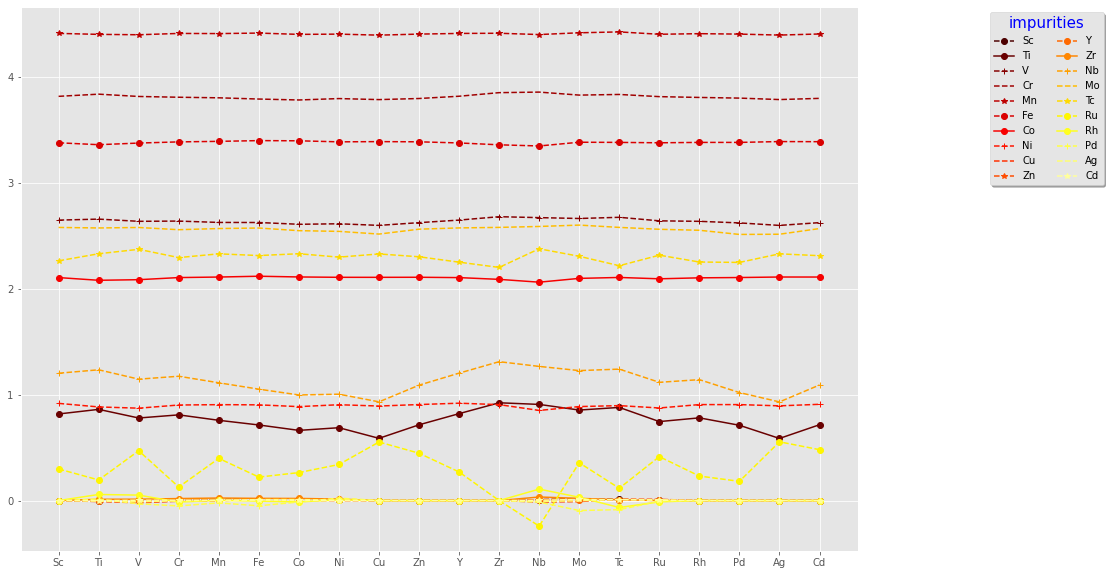

In [12]:
## Some other plots for combined_imps data
## Spin momentum along the z axis taking count only one imp of the two
## TODO: Also add the another data for second same impurity and average them, The calcualation AB and BA

group = 102
import matplotlib as mpl

mpl.style.use('ggplot')
spin_data_array, spin_xtick_labels, spin_ytick_labels = ExtractLastCalcData(group, Average= False, key1 = 'magnetism_group', key2='spin_moment_per_atom' , key3=0, key4=2)
## here the parameter 'average' should set to be false as here nothing to be average as this anly use for np.array 

# spin_data_array
arr_shape= np.shape(spin_data_array)
max_val= np.max(spin_data_array)
min_val= np.min(spin_data_array)
xtick_loc= range(len(spin_xtick_labels[1:]))
xtick_lab = spin_xtick_labels[1:]


n = arr_shape[0]
color = plt.cm.hot_r(np.linspace(0.1,0.9,n)) # This returns RGBA; convert:
line_design= ['o--', 'o-', '+--', '--', '*--']
    
fig, ax_zs_mom= plt.subplots(1,1, figsize=(15,10))
for i in range(arr_shape[0]):
    
    line= list(spin_data_array[i,1:])
    ax_zs_mom.plot(line, line_design[i%len(line_design)], label=f'{spin_ytick_labels[i]}', color= color[n-1-i])
leg= ax_zs_mom.legend(loc= 'upper right', shadow= True, bbox_to_anchor=[1.3,1],  ncol= 2, title="impurities", fancybox= True )
leg.get_title().set_color('blue')
leg.get_title().set_fontsize(15)
plt.xticks(xtick_loc, xtick_lab)
plt.show()


len of plot_imp_row_list 20
len of plot_imp_col_list 21
['X', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd']
['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd']
len of plot_imp_row_list 20
len of plot_imp_col_list 20
len of plot_imp_row_list 20
len of plot_imp_col_list 20
len of plot_imp_row_list 20
len of plot_imp_col_list 20


Text(0.35, 0.5, 'imp_index: (0, 15), Distance: 0.5822211212787 alat; 1 alat= 8.2826 Bohr')

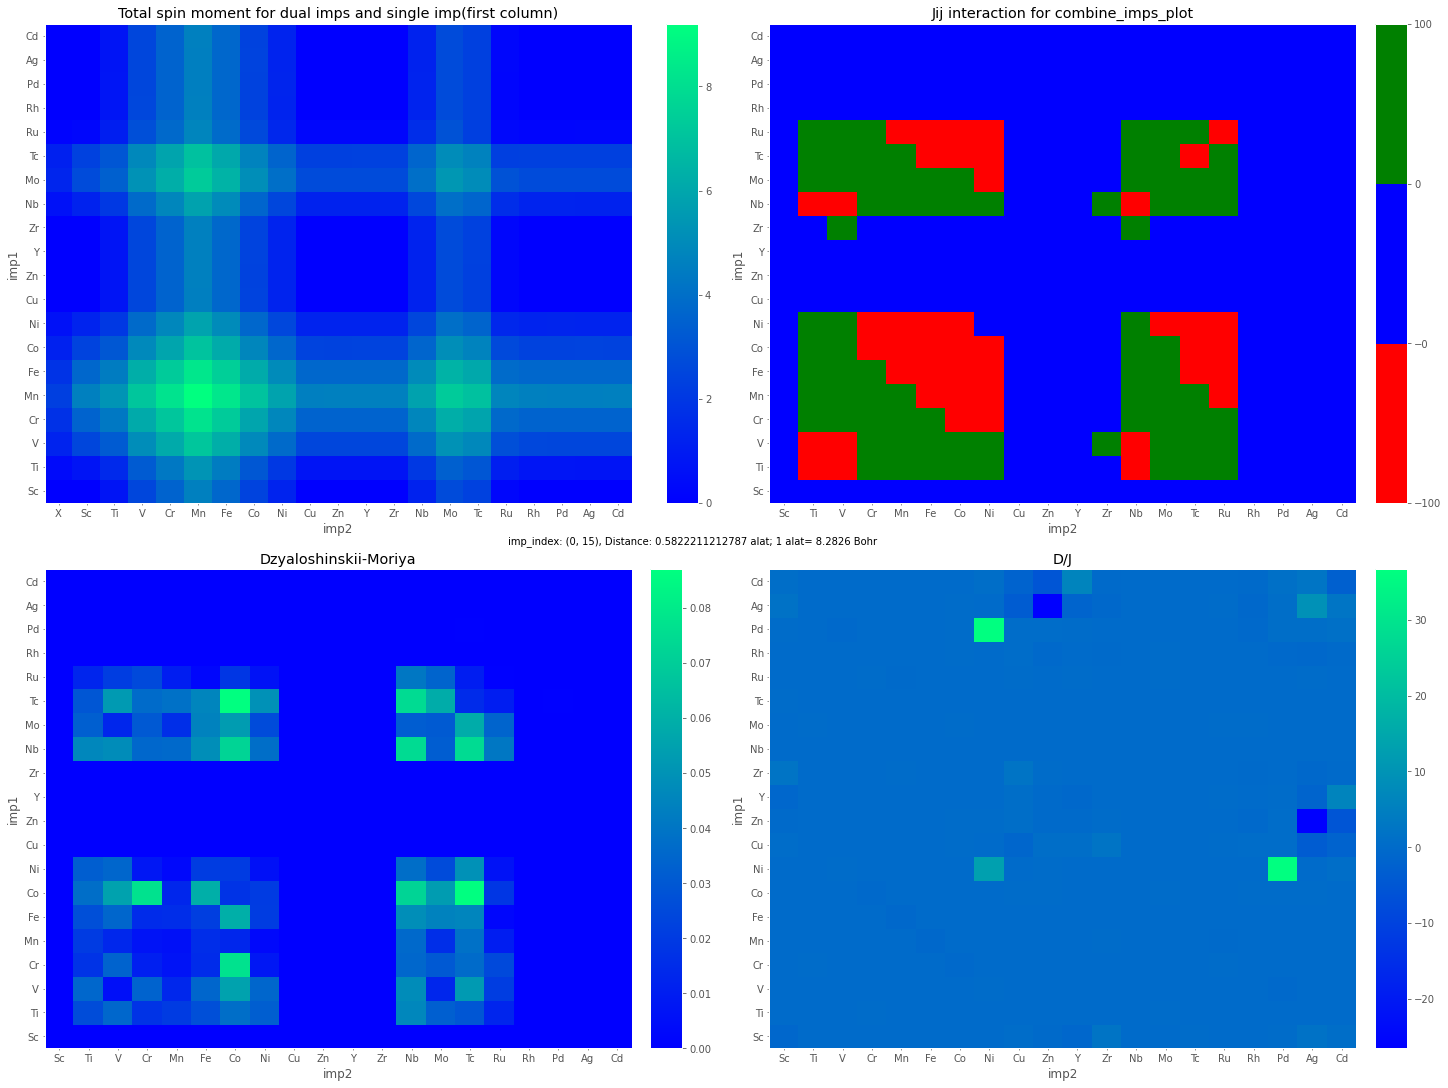

In [13]:
### Plot the figures for any specific group
group = 104
## Collect plot data
spin_data_array, spin_xtick_labels, spin_ytick_labels = ExtractLastCalcData(group, key1 = 'magnetism_group', key2='total_spin_moment')
Jij_data_array, Jij_xtick_labels, Jij_ytick_labels, some_info_dict  = ExtractJijData(group, jij_data_position=3)
DM_data_array, DM_xtick_labels, DM_ytick_labels, some_info_dict = ExtractJijData(group, jij_data_position=4)
DRatioJ_data_array, DRatioJ_xtick_labels, DRatioJ_ytick_labels, some_info_dict = ExtractJijData(group, D_dev_J=True)

## starts ploting
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import ticker
%matplotlib inline

xtick_points = [list(range(np.shape(spin_data_array)[1])), list(range(np.shape(Jij_data_array)[1])), list(range(np.shape(DM_data_array)[1])), list(range(np.shape(DRatioJ_data_array)[1]))]
# xtick_points = np.add(xtick_points, 0.5)#.tolist()

xtick_labels = [spin_xtick_labels, Jij_xtick_labels, DM_xtick_labels, DRatioJ_xtick_labels]

ytick_points = [list(range(np.shape(spin_data_array)[0])), list(range(np.shape(Jij_data_array)[0])), list(range(np.shape(DM_data_array)[0])), list(range(np.shape(DRatioJ_data_array)[0]))]
ytick_labels = [spin_ytick_labels, Jij_ytick_labels, DM_ytick_labels, DRatioJ_ytick_labels]

array_data = [spin_data_array, Jij_data_array, DM_data_array, DRatioJ_data_array]
label_x_y = [['imp2','imp1'], ['imp2','imp1'], ['imp2','imp1'],  ['imp2','imp1']]
title = ['Total spin moment for dual imps and single imp(first column)', 'Jij interaction for combine_imps_plot'
        , 'Dzyaloshinskii-Moriya', 'D/J' ]

fig, axs = plt.subplots(2,2, constrained_layout=True, figsize=(20,15), )

# fig.figsize
cmap0 = plt.cm.get_cmap('winter')#.set_bad(color='white', )
norm0 = None

### here to create the color map as cmap

bounds = [-100,-0.01,0.01,100]
colors = ["r", "b", "g"]
cmap1 = matplotlib.colors.ListedColormap(colors )
norm1 = matplotlib.colors.BoundaryNorm(bounds, len(colors))
#TODO: Change the label points to the locator
### create cmap ends here
cmap = [cmap0, cmap1, cmap0, cmap0]
norm = [norm0, norm1, norm0, norm0]
i = 0
for ax in axs.ravel():
    if len(axs.ravel()) > len(array_data):
        continue
    img = ax.pcolormesh(array_data[i], cmap=cmap[i], norm=norm[i], rasterized=True)
    cm = fig.colorbar(img, ax=ax)
    
    ## Centering the xtick with formatter and locator
    xtick_locator = np.add(xtick_points[i], 0.5).tolist()
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.xaxis.set_minor_locator(ticker.FixedLocator(xtick_locator))
    ax.xaxis.set_minor_formatter(ticker.FixedFormatter(xtick_labels[i]))
    
    ## centring the yticks with formatter and locator
    ytick_locator = np.add(ytick_points[i], 0.5).tolist()
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_minor_locator(ticker.FixedLocator(ytick_locator))
    ax.yaxis.set_minor_formatter(ticker.FixedFormatter(ytick_labels[i]))

    
    ax.set_xlabel(label_x_y[i][0])
    ax.set_ylabel(label_x_y[i][1])
    ax.set_title(title[i])
#     ax.xti
    i += 1
imp_index = some_info_dict['some_info']['imp_indices']
atom_distance = some_info_dict['some_info']['atom_distance']
alat = some_info_dict['some_info']['alat']
msg = f'imp_index: {imp_index}, Distance: {atom_distance} alat; 1 alat= {alat} Bohr'
plt.figtext(x=0.35,y=0.5,s=msg)
# plt.savefig('ilayers_3_3.pdf')

len of plot_imp_row_list 20
len of plot_imp_col_list 21
['X', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd']
['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd']
len of plot_imp_row_list 20
len of plot_imp_col_list 20
len of plot_imp_row_list 20
len of plot_imp_col_list 20
len of plot_imp_row_list 20
len of plot_imp_col_list 20


Text(0.35, 0.5, 'imp_index: (0, 15), Distance: 0.5822211212787 alat; 1 alat= 8.2826 Bohr')

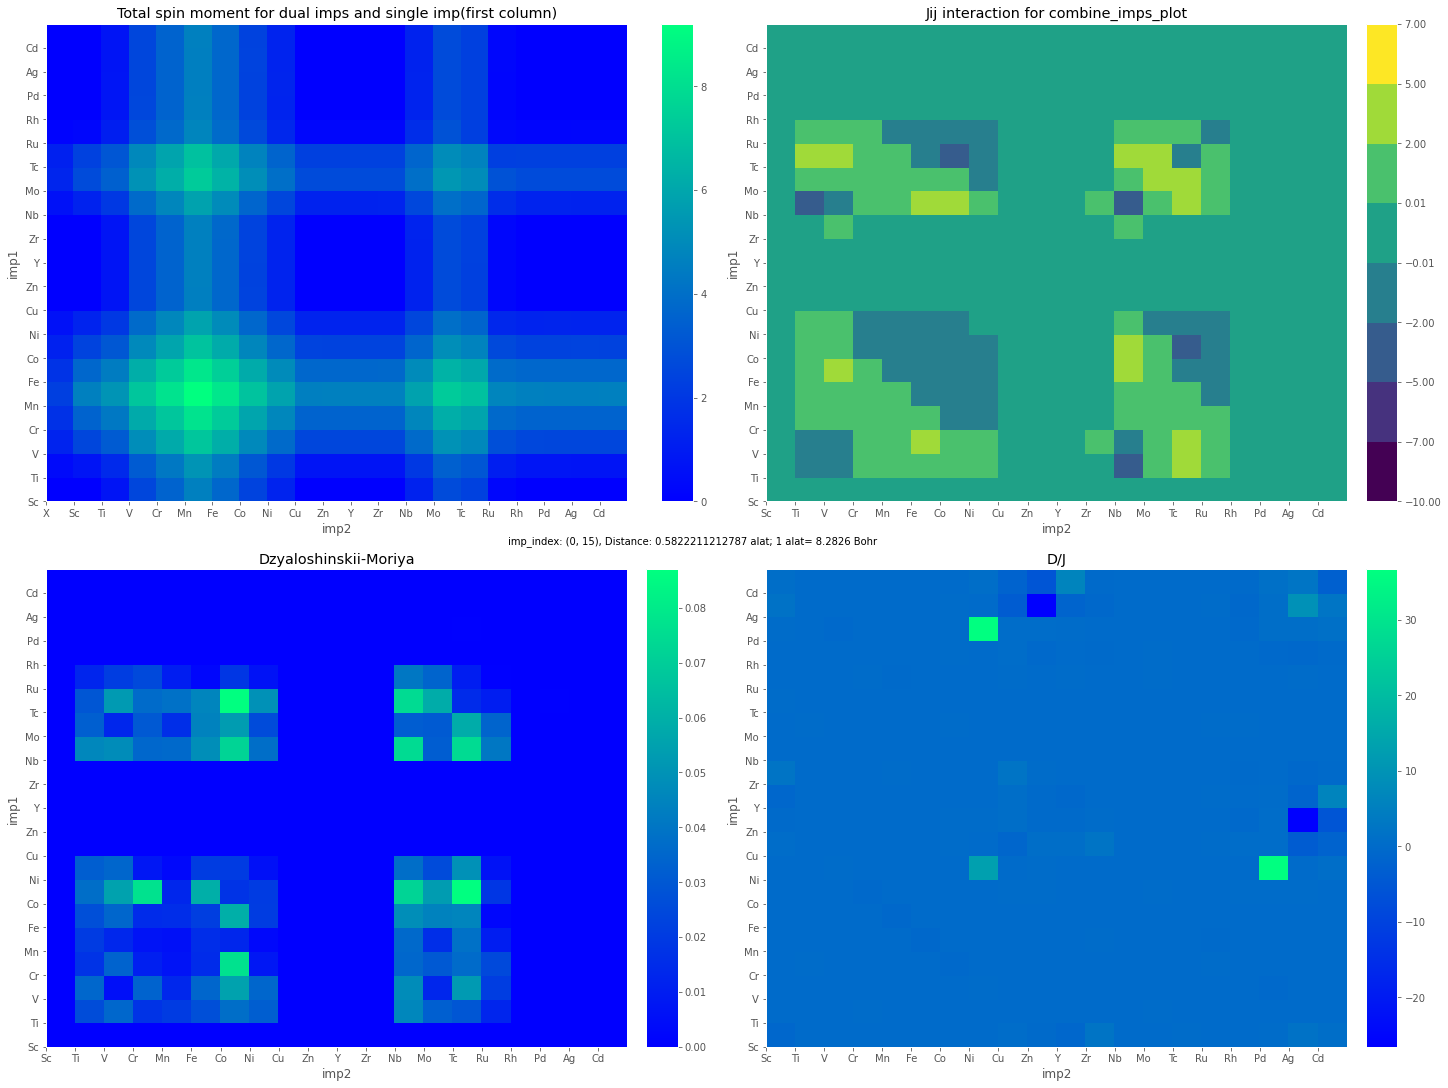

In [14]:
### Plot the figures for any specific group
group = 104

# ## Collect plot data
spin_data_array, spin_xtick_labels, spin_ytick_labels = ExtractLastCalcData(group, key1 = 'magnetism_group', key2='total_spin_moment')
Jij_data_array, Jij_xtick_labels, Jij_ytick_labels, some_info_dict  = ExtractJijData(group, jij_data_position=3)
DM_data_array, DM_xtick_labels, DM_ytick_labels, some_info_dict = ExtractJijData(group, jij_data_position=4)
DRatioJ_data_array, DRatioJ_xtick_labels, DRatioJ_ytick_labels, some_info_dict = ExtractJijData(group, D_dev_J=True)

## starts ploting
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

xtick_points = [range(np.shape(spin_data_array)[1]), range(np.shape(Jij_data_array)[1]), range(np.shape(DM_data_array)[1]), range(np.shape(DRatioJ_data_array)[1])]
xtick_labels = [spin_xtick_labels, Jij_xtick_labels, DM_xtick_labels, DRatioJ_xtick_labels]

ytick_points = [range(np.shape(spin_data_array)[0]), range(np.shape(Jij_data_array)[0]), range(np.shape(DM_data_array)[0]), range(np.shape(DRatioJ_data_array)[0])]
ytick_labels = [spin_ytick_labels, Jij_ytick_labels, DM_ytick_labels, DRatioJ_ytick_labels]

array_data = [spin_data_array, Jij_data_array, DM_data_array, DRatioJ_data_array]
label_x_y = [['imp2','imp1'], ['imp2','imp1'], ['imp2','imp1'],  ['imp2','imp1']]
title = ['Total spin moment for dual imps and single imp(first column)', 'Jij interaction for combine_imps_plot'
        , 'Dzyaloshinskii-Moriya', 'D/J' ]

fig, axs = plt.subplots(2,2, constrained_layout=True, figsize=(20,15),  )

# fig.figsize
cmap0 = plt.cm.get_cmap('winter')#.set_bad(color='white', )
norm0 = None

### here to create the color map as cmap

bounds = [-10, -7, -5, -2, -0.01, 0.01, 2, 5, 7]
colors = [[0.267004, 0.004874, 0.329415, 1.],
 [0.275191, 0.194905, 0.496005, 1.],
 [0.212395, 0.359683, 0.55171,  1.],
 [0.153364, 0.497,    0.557724, 1.],
 [0.122312, 0.633153, 0.530398, 1.],
 [0.288921, 0.758394, 0.428426, 1.],
 [0.626579, 0.854645, 0.223353, 1.],
 [0.993248, 0.906157, 0.143936, 1.]]
# colors = ["r", "b", "g"]

### color also can be created in this way-------

# viridis= plt.cm.get_cmap('viridis',256)
# color= viridis(np.linspace(0,1, 3))
# cmap= mpl.colors.ListedColormap(color)

###--------------------------------------
cmap1 = matplotlib.colors.ListedColormap(colors )
norm1 = matplotlib.colors.BoundaryNorm(bounds, len(colors))

### create cmap ends here
cmap = [cmap0, cmap1, cmap0, cmap0]
norm = [norm0, norm1, norm0, norm0]
i = 0
for ax in axs.ravel():
    if len(axs.ravel()) > len(array_data):
        continue
    img = ax.pcolormesh(array_data[i], cmap=cmap[i], norm=norm[i], rasterized=True)
    cm = fig.colorbar(img, ax=ax)
    
    ax.set_xticks(xtick_points[i])
    ax.set_xticklabels(xtick_labels[i])
    
    ax.set_yticks(ytick_points[i])
    ax.set_yticklabels(ytick_labels[i])
    
    ax.set_xlabel(label_x_y[i][0])
    ax.set_ylabel(label_x_y[i][1])
    ax.set_title(title[i])
    i += 1
imp_index = some_info_dict['some_info']['imp_indices']
atom_distance = some_info_dict['some_info']['atom_distance']
alat = some_info_dict['some_info']['alat']
msg = f'imp_index: {imp_index}, Distance: {atom_distance} alat; 1 alat= {alat} Bohr'
plt.figtext(x=0.35,y=0.5,s=msg,)
# plt.subplots_adjust(botom=1.0)# margins(0.5)
# plt.savefig('ilayers_3_4.pdf')